---

# CSCI 3202, Fall 2021
# Homework 5
# Due: Friday November 19, 2021 at 6:00 PM

<br> 

### Your name: Xiang Chen

<br> 


---
## Problem 1: Navigating an awkward situation with grace and poise

<img src='https://www.explainxkcd.com/wiki/images/5/5f/interaction.png' style="width: 600px;"/>


Suppose you are at a social event where you would like to avoid any interaction with a large number of the other attendees. It's not that you don't like them, it's just that you don't like *talking to* them. A few of your good friends are also in attendance, but they are tucked away in a corner. The rectangular room in which the event is being held spans gridcells at $x=1,2,\ldots, 6$ and $y=1,2,\ldots, 5$. At the eastern edge ($x=6$) of this first floor room, there is a balcony, with a 6-foot drop. If the event becomes unbearably awkward, you can jump off the balcony and run away. Of course, this might hurt a little bit, so we should incorporate this into our reward structure.

The terminal states and rewards associated with them are given in the diagram below. The states are represented as $(x,y)$ tuples. The available actions in non-terminal states include moving exactly 1 unit North (+y), South (-y), East (+x) or West (-x), although you should not include walking into walls, because that would be embarrassing in front of all these other people. Represent actions as one of 'N', 'S', 'E', or 'W'. For now, assume all non-terminal states have a default reward of -0.01, and use a discount factor of 0.99.

<img src="http://www.cs.colorado.edu/~tonyewong/home/resources/hw06_mdp.png" style="width: 400px;"/>

Use the following transition model for this decision process, if you are trying to move from state $s$ to state $s'$:
* you successfully move from $s$ to $s'$ with probability 0.6
* the remaining 0.4 probability is spread equally likely across state $s$ **and** all adjacent (N/S/E/W) states except for $s'$. Note that this does not necessarily mean that all adjacent states have 0.1, because some states do not have 4 adjacent states.


### (1a)

Complete the `MDP` class below. The docstring comments provide some desired specifications. You may add additional methods or attributes, if you would like.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib import colors
import copy
import unittest

In [2]:
dict_direction = {'N':(0,1),'S':(0,-1),'E':(1,0),'W':(-1,0)}
#normal_reward = 0.01
class MDP:
    def __init__(self, nrow, ncol, terminal, default_reward, discount, small_reward):
        '''Create/store the following attributes:
        states -- list of all the states (x,y) tuples
        terminal_states -- is a dictionary with terminal state keys, and rewards as values
        default_reward -- is the reward for being in any non-terminal state
        df -- discount factor
        ... and anything else you decide will be useful!
        '''
        
        # your code goes here...
        self.states = []
        for c in range(1, ncol+1):
            for r in range(1, nrow+1):
                self.states.append((r,c))
        self.terminal_states = terminal
        self.default_reward = default_reward
        self.df = discount
        self.nrow = nrow
        self.ncol = ncol
        self.small_reward = small_reward

    def actions(self, state):
        '''Return a list of available actions from the given state.
        [None] are the actions available from a terminal state.
        '''
        
        #direction = [(1,0),(-1,0),(0,1),(0,-1)]
        action = ['S','N','E','W']
        if(state in self.terminal_states):
             return [None]
        answer = []
        for i in dict_direction.keys():
            if((state[0]+dict_direction[i][0], state[1]+dict_direction[i][1]) in self.states ):
                #if((state[0]+dict_direction[i][0], state[1]+dict_direction[i][1]) in self.terminlal_states):
                  #  answer.append(None)
                answer.append(i)
        return answer
        # your code goes here...
        
        
        
    def reward(self, state):
        '''Return the reward for being in the given state'''
        if(state in self.default_reward.keys()):
            return self.default_reward[state]
        else:
            return self.small_reward
        
        # your code goes here...

        
        
    def result(self, state, action):
        '''Return the resulting state (as a tuple) from doing the given
        action in the given state, without uncertainty. Uncertainty
        is incorporated into the transition method.
        state -- a tuple representing the current state
        action -- one of N, S, E or W, as a string
        '''
        
        # your code goes here...
        
        return (state[0] + dict_direction[action][0],state[1] + dict_direction[action][1] )
        #return state
        
        
                
    def transition(self, state, action):
        '''Return the probabilities and subsequent states associated
        with taking the given action from the given state. Can be done
        however you want, so that it works with your value/policy iteration.
        '''
        #assume state will not be the terminal state
        answer = [((0.6,self.result(state,action)))]
        remaining = self.actions(state)
        rest_prob = 0.4 / (len(remaining) - 1)
        for i in remaining:
            if(i != action):
                answer.append((rest_prob, self.result(state,i)))
        return answer
        # your code goes here...
        

**Now:** create an `MDP` object to represent the decision process in this problem.

To test and get comfortable with your `MDP` class methods and attributes, and making the relevant calculations with this structure, calculate the expected utility of walking north from (1,1). Assume initially that all states $(x,y)$ have a utility of $x+y$ (including the terminal states).

In [3]:
utility_dict = {}
coln = 5
rown = 6
for c in range(coln):
    for r in range(rown):
        utility_dict[(c,r)] = c+r
default_reward = {(1,4): 2,(1,5): 2,(3,5) : 1, (1,3):-1, (2,1):-1,(3,1):-1, (3,4):-1, (4,3):-1,(4,4):-1,(6,1):-5, (6,2):-5, (6,3):-5, (6,4):-5, (6,5):-5, }
first_mdp = MDP(rown, coln,default_reward.keys() ,default_reward, 0.99, -0.01)
print(first_mdp.result((1,1),'N'))


(1, 2)


### (1b)

Implement value iteration to calculate the utilities for each state.  Also implement a function that takes as arguments an `MDP` object and a dictionary of state-utility pairs (key-value) and returns a dictionary for the optimal policy.  The optimal policy dictionary should have state tuples as keys and the optimal move (None, N, S, E or W) as values.

In [4]:
def calculate_each_step(copy_u, mdp, state, act):
    tran = mdp.transition(state, act)
    sum = 0
    for i in tran:
        sum += (i[0] * copy_u[i[1]])
    return sum

def value_iteration(mdp, tol=1e-3):
    # your code goes here... 
    init_utility = {s : 0 for s in mdp.states}
    time = 0
    max_change = 0
    while True:
        new_utility = init_utility.copy()
        flag = -999
        for s in mdp.states:
            all_action = mdp.actions(s)
            net_lst = []
            if(all_action == [None]):
                new_utility[s] = mdp.reward(s)
                continue
            for a in all_action:
                net_lst.append(calculate_each_step(init_utility, mdp, s, a))
                new_utility[s] = mdp.reward(s) + mdp.df * max(net_lst)
                max_change = max(flag, abs((new_utility[s] - init_utility[s])))
        init_utility = new_utility.copy()   
        #time += 1
        if(max_change < tol):
            break
    #print("run time total", time) 
    return new_utility

def find_policy(mdp, utility):   
    # your code goes here...
    optimal_dict = {}
    for s in mdp.states:
        temp_action = mdp.actions(s)
        if(temp_action == [None]):
            optimal_dict[s] = [None]
        else:
            lst = [utility[(s[0]+dict_direction[a][0], s[1]+dict_direction[a][1])] for a in temp_action]
            optimal_dict[s] = temp_action[lst.index(max(lst))]

    return optimal_dict
def print_policy(dictonary, start):
    print(start)
    while dictonary[start] != [None]:
        print(dictonary[start])
        start = (start[0] + dict_direction[dictonary[start]][0] , start[1] + dict_direction[dictonary[start]][1])
        
first_utility = value_iteration(first_mdp)
optimal_dict = find_policy(first_mdp,first_utility )

Now actually use your `value_iteration` and `find_policy` functions to calculate the utility for each state in this MDP, and the optimal action in each state.

As a sanity check, print the utilities of these terminal states:
1. `utility[(1,5)]`
1. `utility[(6,1)]`

and print the utility of these states that are nearby to terminal states, so their utilities should be similar to the nearby terminal states' utilities:
1. `utility[(2,5)]`
1. `utility[(5,3)]`

And print the policy for these states to make sure they make sense:
1. `policy[(2,4)]`
1. `policy[(1,1)]`

In [5]:
print(first_utility[(1,5)])
print(first_utility[(6,1)])

2
-5


In [6]:
print(first_utility[(2,5)])
print(first_utility[(5,3)])

1.6440205045410357
-1.6767012909499


In [7]:
print_policy(optimal_dict, (2,4))
print_policy(optimal_dict, (1,1))

(2, 4)
W
(1, 1)
N
E
N
N
W


### (1c)

If we enter the room at (5,1), what is the optimal path for us to follow?  Create a graphic to illustrate this policy pathway, either by generating a plot in Python (like the maze solution path) or by uploading a hand-drawn image and including it below.

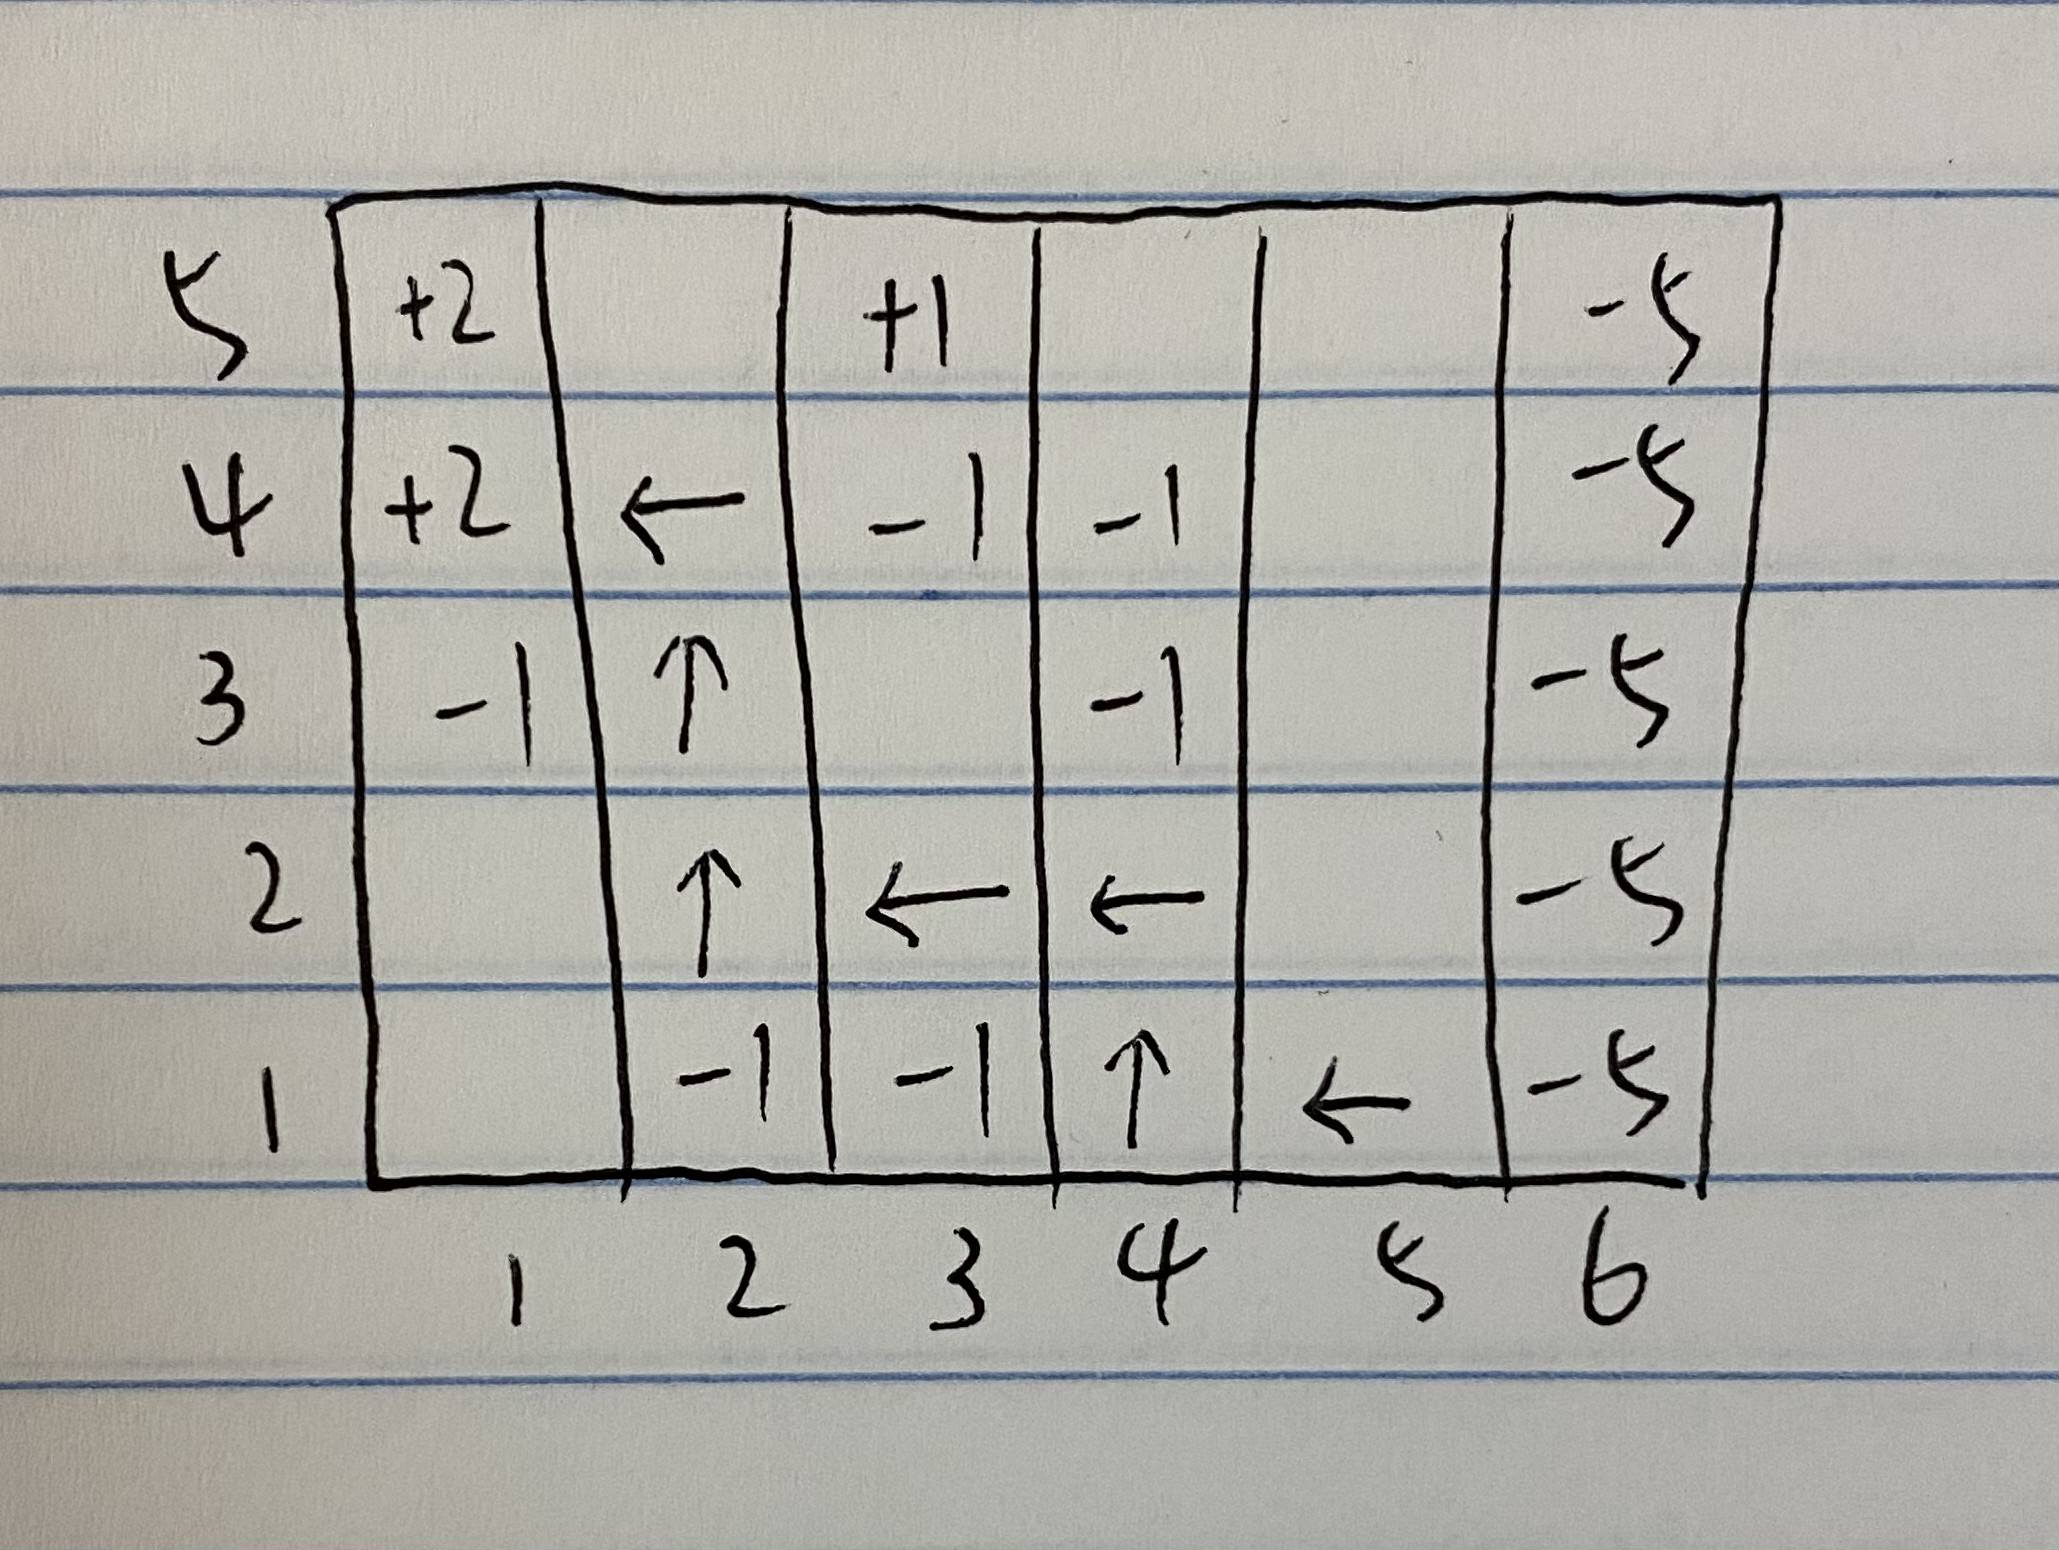

### (1d)

From (3,2) the optimal move is to walk West. If we are trying to go talk to our friends in the Northwest corner, why would we rather do this than walk North first, then West?

we want to avoid a negative reward since we need to go through a person we don't want to talk about

### (1e)

How painfully awkward do you need to set the default reward for non-terminal states before the optimal move from (5,1) becomes jumping off the balcony immediately and running away?  Round your answer to two decimal places.

In [8]:
default_reward = {(1,4): 2,(1,5): 2,(3,5) : 1, (1,3):-1, (2,1):-1,(3,1):-1, (3,4):-1, (4,3):-1,(4,4):-1,(6,1):-5, (6,2):-5, (6,3):-5, (6,4):-5, (6,5):-5, }
second_mdp = MDP(rown, coln,default_reward.keys() ,default_reward, 0.99, -2.01)
second_utility = value_iteration(second_mdp)
optimal_dict2 = find_policy(second_mdp,second_utility )
print_policy(optimal_dict2, (5,1))
#print("staying at (5,1) with non-terminal reward = -2.01, recommend to go ")
#print_policy(optimal_dict2, (5,1))

(5, 1)
E


when non-terminal reward = -2.01



When the absolute value of non-terminal reward is still greater than the maximum reward of talking with friend, jumping out of balcony and run away is better option.

### (1f)

In **1e** we assumed a certain level of loss (negative reward) just for being present.  But a more realistic approach might be to instead change the reward structure for the terminal states. Consider the terminal states with -1 reward in the default model. Let $R^*$ denote the reward associated with these states. How low does $R^*$ need to be in order for us to immediately jump off the balcony and run away? Use the default non-terminal state reward of -0.01. Write a few sentences interpreting your result.

In [9]:
low_reward = -0.007
default_reward = {(1,4): 2,(1,5): 2,(3,5) : 1, (1,3):low_reward, (2,1):low_reward,(3,1):low_reward, (3,4):low_reward, (4,3):low_reward,(4,4):low_reward,(6,1):-5, (6,2):-5, (6,3):-5, (6,4):-5, (6,5):-5, }
third_mdp = MDP(rown, coln,default_reward.keys() ,default_reward, 0.99, -0.01)
third_utility = value_iteration(third_mdp)
optimal_dict3 = find_policy(third_mdp,third_utility )
print_policy(optimal_dict3, (5,1))

(5, 1)
W
N
W
W
N
N
W


$R^*$ deos not influence whether we will jump off the balcony, since talking with friend will always be a posivtive reward after reaching, negative reward of terminal states might effect the optimal path to terminal states, but it won't lead us to jump off the balcony

### (1g)

Given the problem context, write a few sentences about why this is or is not an appropriate transition model. Include an interpretation of the terminal states.

It's an appropriate transition model because we introduce uncertainty so that every move might be the desired one. And the reward of terminal states are set appropriately so that machine can know which terminal states are the desired one. After many attempts, the machine can find the optimal move for each non-terminal states.

<br>

---

## Problem 2: HMMs

You are trying to diagnose whether your computer is broken or not. On a given day, your computer's hidden state is either *broken* or *working*. Each day you make one of the following observations: *blue-screen*, *slow*, or *snappy*, depending on the state of your computer. You decide to use the following HMM to model your daily observations. Note, "Emission Distribution" is another way to descibe the "Sensor Distribution".

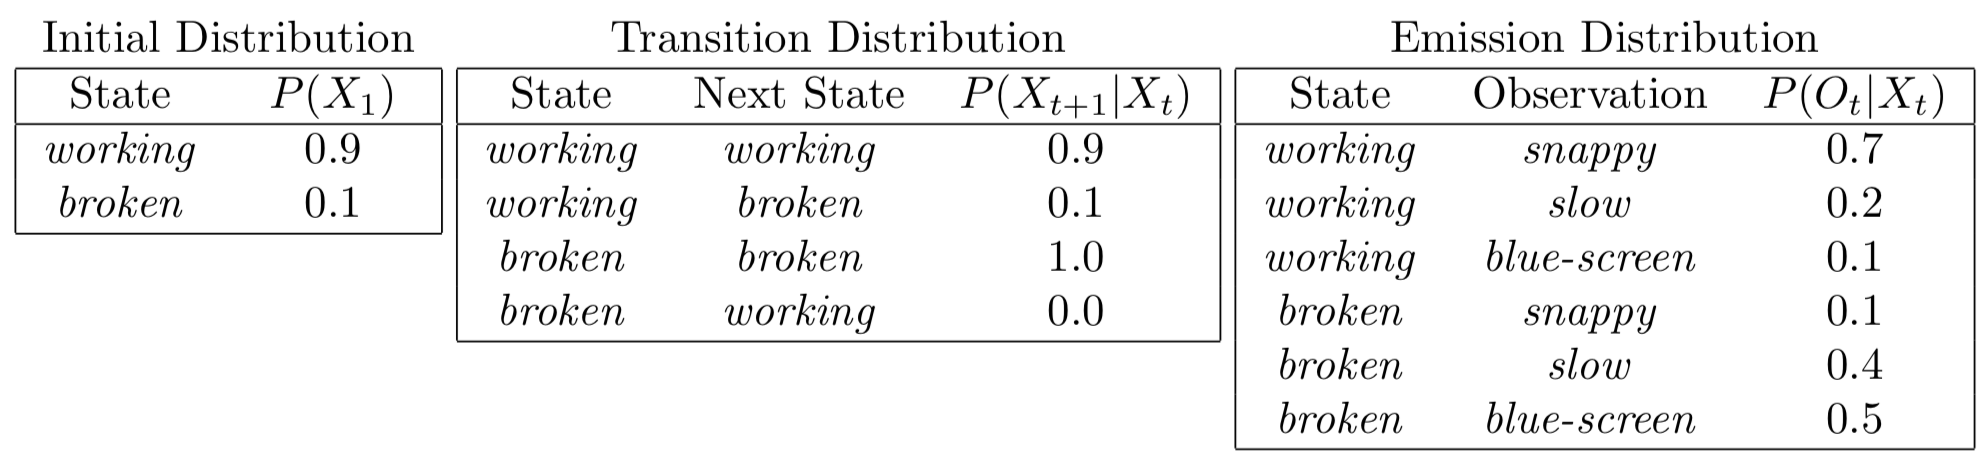


### (2a)
What is the posterior distribution of $X_1$, your computer's state on day one, given the observation (*slow*) on day 1? In other words, find $P(X_1 | E_1 = \textit{slow})$.

$$P(X_1|E_1=slow)=\frac{P(E_1=slow |X_1)P(X_1|E_1=slow)}{P(E_1=slow)}$$

$$P(X_1|E_1=slow)=\alpha P(E_1=slow |X_1)P(X_1|E_1=slow)$$

$$P(X_1|E_1=slow)=\alpha forward P(X_0,E_1=slow)$$

$$P(X_1|E_1=slow) = \alpha \cdot
\left(\begin{array}{cc} 
0.2 & 0\\
0 & 0.4
\end{array}\right)(
\left(\begin{array}{cc} 
0.9 \\ 
0.1 
\end{array}\right)\cdot 0.9+
\left(\begin{array}{cc} 
0 \\ 
1.0 
\end{array}\right)\cdot 0.1
)
$$ 

$$P(X_1|E_1=slow) = \alpha \cdot
\left(\begin{array}{cc} 
0.2 & 0\\
0 & 0.4
\end{array}\right)
(
\left(\begin{array}{cc} 
0.81 \\ 
0.1 
\end{array}\right
))
$$ 

$$P(X_1|E_1=slow) = \alpha \cdot
\left(\begin{array}{cc} 
0.162\\
0.04
\end{array}\right)
$$ 


$$\alpha = \frac{1}{0.162+0.04}=4.950495$$

$$P(X_1|E_1=slow)=
\left(\begin{array}{cc} 
0.801980\\
0.1980198
\end{array}\right)
$$

### (2b)
What is the posterior distribution of $X_2$, your computer's state on day two, given the observation sequence (*slow*, *slow*)?

$$P(X_2|E_2=slow)=\alpha forward P(X_1,E_1=slow)$$

$$P(X_2|E_2=slow) = \alpha \cdot
\left(\begin{array}{cc} 
0.2 & 0\\
0 & 0.4
\end{array}\right)(
\left(\begin{array}{cc} 
0.9 \\ 
0.1 
\end{array}\right)\cdot 0.801980+
\left(\begin{array}{cc} 
0 \\ 
1.0 
\end{array}\right)\cdot 0.1980198
)
$$ 

$$P(X_2|E_2=slow) = \alpha \cdot
\left(\begin{array}{cc} 
0.2 & 0\\
0 & 0.4
\end{array}\right)
(
\left(\begin{array}{cc} 
0.721782 \\ 
0.2782178
\end{array}\right
))
$$ 

$$P(X_2|E_2=slow) = \alpha \cdot
\left(\begin{array}{cc} 
0.1443564\\
0.111287
\end{array}\right)
$$ 


$$\alpha = \frac{1}{0.1443564+0.111287}=3.9117$$

$$P(X_2|E_2=slow)=
\left(\begin{array}{cc} 
0.564679\\
0.435321
\end{array}\right)
$$

<br>

---

## Problem 3: your very own MDP

For this problem, you do not need to write any code, but rather communicate your ideas clearly using complete sentences and descriptions of the concepts the questions ask about. You can, of course, include some pseudocode if it helps, but that is not strictly necessary.

### (3a)

Describe something you think would be interesting to model using a Markov decision process.  Be **creative** - do not use any examples from your homework, class, or the textbook, and if you are working with other students, please **come up with your own example**. There are so, SO many possible answers!

a self-learning storage management system which is designed to quickly find the driver full of cache to clean up. The Every hard disk driver will store user profile or cache. The system will scan all driver every night and the find the driver that already full of cache to delete. If system delete a driver full of cache, system will get a positive reward. If system delete driver with user profile, system will get a negative reward, assuming system always can get back the driver it deleted, so that no user profile will lost. 

### (3b)

What are the states associated with your MDP?

driver with user profile, driver with full cache, driver with non-full cache

### (3c)

What is the reward structure associated with your MDP?  Include a discussion of terminal/non-terminal states.

terminal states means system clean up a driver


non-terminal states means system are scanning to check  whether is user profile or cache and whether it is full

reward of delete a full cache driver will be positive, reward of delete any other driver will be negative, non-terminal state will be a small negative number

### (3d)

What are the actions and transition model associated with your MDP?

action is cleaning up the driver

transition model indicates that when system tries to clean up a driver, it might delete other driver around its current position

### (3e)

Interpret what an optimal policy represents in the context of your particular MDP.

Given multiple driver, the system can quickly find the driver full of cache to clean up